In [1]:
import pandas as pd
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
from loguru import logger

In [2]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
os.chdir(os.environ.get("ROOT_DIR"))
from src import DATA_DIR
raw_data_dir = DATA_DIR / 'raw'

In [3]:
# Read in all patterns files in the monthly-patterns folder

patterns_path = raw_data_dir / "monthly-patterns"
files = []
for f in patterns_path.glob("**/*.csv.gz"):
    files.append(f)

In [13]:
def filter_to_philly(df):
    # zip codes are read as integers rather than strings so we add leading zeros.
    # this is not strictly necessary since Philadelphia zipcodes don't have leading zeros.
    
    # Philadelphia selection
    # HK: adding leading zeros because some zipcodes in MA are 0191X.
    df['postal_code'] = df['postal_code'].apply(lambda x: ('00000'+str(x))[-5:])
    in_philly = df['postal_code'].astype(str).str.startswith("191")
    df = df.loc[in_philly]
    df = df[['safegraph_place_id','date_range_start','postal_code', 
             'raw_visit_counts', 'raw_visitor_counts']]
    
    return df

In [14]:
philly_patterns = []
for i, f in enumerate(files):
    print(f)
    philly_patterns.append(filter_to_philly(pd.read_csv(f)))
    
philly_patterns = pd.concat(philly_patterns)

/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/11/06/11/patterns-part3.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/11/06/11/patterns-part1.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/11/06/11/patterns-part4.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/11/06/11/patterns-part2.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/10/07/02/patterns-part3.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/10/07/02/patterns-part1.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/10/07/02/patterns-part4.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns/2020/10/07/02/patterns-part2.csv.gz
/Users/hannahkro

/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns_backfill/2020/05/07/12/2019/01/patterns-part4.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns_backfill/2020/05/07/12/2019/01/patterns-part2.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns_backfill/2020/05/07/12/2019/06/patterns-part3.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns_backfill/2020/05/07/12/2019/06/patterns-part1.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns_backfill/2020/05/07/12/2019/06/patterns-part4.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns_backfill/2020/05/07/12/2019/06/patterns-part2.csv.gz
/Users/hannahkronenberg/SafegraphCOVIDPhilly/src/../data/raw/monthly-patterns/patterns_backfill/2020/05/07/12/2019/12/patterns-part3.csv.gz
/Users/hannahkronenb

In [15]:
philly_patterns.head()

,safegraph_place_id,date_range_start,postal_code,raw_visit_counts,raw_visitor_counts
408,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-10-01T00:00:00-04:00,19107,7,7
536,sg:32b17bf96a93444588131370e52d310d,2020-10-01T00:00:00-04:00,19140,168,96
683,sg:3f4865e8bbb249838350eee9a101c8eb,2020-10-01T00:00:00-04:00,19140,75,47
1236,sg:76dbefabe6eb465fac98e62c2fb15be9,2020-10-01T00:00:00-04:00,19140,322,234
1600,sg:9b2b12ebfa7745b6814873b7c1cef76b,2020-10-01T00:00:00-04:00,19118,93,46


In [16]:
philly_patterns.to_csv(
    DATA_DIR / "processed" / "kmeans_patterns.csv.tar.gz", index=False
)

In [17]:
philly_patterns.head()

,safegraph_place_id,date_range_start,postal_code,raw_visit_counts,raw_visitor_counts
408,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-10-01T00:00:00-04:00,19107,7,7
536,sg:32b17bf96a93444588131370e52d310d,2020-10-01T00:00:00-04:00,19140,168,96
683,sg:3f4865e8bbb249838350eee9a101c8eb,2020-10-01T00:00:00-04:00,19140,75,47
1236,sg:76dbefabe6eb465fac98e62c2fb15be9,2020-10-01T00:00:00-04:00,19140,322,234
1600,sg:9b2b12ebfa7745b6814873b7c1cef76b,2020-10-01T00:00:00-04:00,19118,93,46


In [87]:
philly_patterns['date_range_start'] = philly_patterns['date_range_start'].apply(lambda x : x[:10])
mask = philly_patterns['date_range_start'] < '2020-03-01' 
prepandemic = philly_patterns.loc[mask,].copy()
pandemic = philly_patterns.loc[~mask,].copy()

In [88]:
prepandemic.date_range_start.unique()

array(['2019-03-01', '2019-04-01', '2019-05-01', '2019-02-01',
       '2019-11-01', '2019-10-01', '2019-07-01', '2019-09-01',
       '2019-08-01', '2019-01-01', '2019-06-01', '2019-12-01',
       '2020-02-01', '2020-01-01'], dtype=object)

In [89]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [90]:
def Stdrshp(df): 
    df = df.pivot(index='safegraph_place_id',columns='date_range_start')[['raw_visit_counts', 'raw_visitor_counts']]
    df = df.fillna(0)
    scaled = StandardScaler().fit_transform(df)
    scaled_features_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
    return scaled_features_df

def make_clusters(df, k = 5):
    kmeans = KMeans(n_clusters=k).fit(df)
    df['cluster'] = kmeans.labels_
    return (df, kmeans.inertia_) 

In [91]:
scaled = Stdrshp(pandemic)
n_clusters = [k for k in range(3,13)]
inertias = []
for k in n_clusters:
    df, inertia = make_clusters(scaled, k = k)
    inertias.append(inertia)

In [92]:
import matplotlib.pyplot as plt

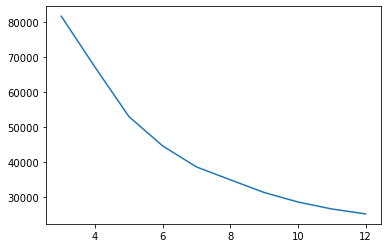

In [93]:
plt.plot(n_clusters,inertias)

In [94]:
prepandemic, prepandemic_inertia = make_clusters(Stdrshp(prepandemic), k = 7 )
pandemic, pandemic_inertia = make_clusters(Stdrshp(pandemic), k = 7 )

In [109]:
pandemic_inertia

38430.259253334494

In [119]:
# We want to compare pandemic_inertia to the inertia we would have in 2020 if we used the
# 2019 clustering
combined = pandemic.join(prepandemic[['cluster']], how='left',rsuffix='pre')
combined[['clusterpre']] = combined[['clusterpre']].fillna(value=-1)
combined['clusterpre'] = combined['clusterpre'].astype(int)

In [120]:
cols = combined.columns
cols = cols[:-2]
n = len(combined.columns)

In [122]:
mask = combined['clusterpre'] > -1

In [125]:
def get_inertia(df, mask, cols, cluster_col):
    n = len(df.index)
    filtered = df[mask]
    m = len(filtered.index)
    se = ((df[cols] - df.groupby(cluster_col)[cols].transform('mean'))**2).to_numpy().sum()
    return se*(n/m)

get_inertia(combined, mask, cols, 'clusterpre')

87731.52003471156

In [126]:
#worst case scenario
combined['newcol'] = 1
get_inertia(combined, mask, cols, 'newcol')

366858.99465962104

In [96]:
df.groupby('cluster').size()

cluster
0      3976
1         1
2        22
3     15629
4         1
5        89
6         1
7         1
8       462
9         3
10        1
11       10
dtype: int64

In [25]:
philly_patterns.head()

,placekey,safegraph_place_id,location_name,street_address,city,region,postal_code,safegraph_brand_ids,brands,date_range_start,...,visitor_work_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type
408,zzw-228@628-pmb-7t9,sg:26825b56c5ce4c7d91afdc71a7c34440,Provident Technology,1315 Walnut St Ste 905,Philadelphia,PA,19107,NaN,NaN,2020-10-01T00:00:00-04:00,...,{},"{""US"":6}",4783.0,8.0,"{""<5"":2,""5-20"":2,""21-60"":0,""61-240"":0,"">240"":3}",{},"{""Dunkin'"":39,""Starbucks"":35,""McDonald's"":28,""...","[1,1,1,1,1,0,0,0,0,1,2,3,2,2,3,2,2,1,0,0,1,1,2,1]","{""Monday"":1,""Tuesday"":2,""Wednesday"":0,""Thursda...","{""android"":0,""ios"":5}"
435,zzy-223@62j-q72-249,sg:2910df09a7264baea5bae7f876ff0423,Arete Rehab,110 Haverhill Rd Ste 344 Arete Rehabilitation,Amesbury Town,MA,1913,NaN,NaN,2020-10-01T00:00:00-04:00,...,{},NaN,NaN,238.0,"{""<5"":0,""5-20"":0,""21-60"":0,""61-240"":1,"">240"":0}",{},"{""Edward Jones"":100}","[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]","{""Monday"":1,""Tuesday"":0,""Wednesday"":0,""Thursda...","{""android"":0,""ios"":0}"
536,22x-222@628-phy-4qf,sg:32b17bf96a93444588131370e52d310d,Los Potrillos Mexican Restaurant,4653 Rising Sun Ave,Philadelphia,PA,19140,NaN,NaN,2020-10-01T00:00:00-04:00,...,{},"{""US"":87}",3335.0,19.5,"{""<5"":8,""5-20"":78,""21-60"":28,""61-240"":37,"">240...","{""Dunkin'"":21,""AAMCO Transmissions"":20,""Family...","{""Dunkin'"":42,""Sunoco"":35,""Wawa"":35,""Dollar Tr...","[7,6,5,6,7,8,11,11,12,18,20,28,28,24,35,30,36,...","{""Monday"":20,""Tuesday"":23,""Wednesday"":22,""Thur...","{""android"":60,""ios"":35}"
683,238-222@628-pj5-3nq,sg:3f4865e8bbb249838350eee9a101c8eb,Precious Babies Learning Academy Day Car,1433 W Erie Ave,Philadelphia,PA,19140,NaN,NaN,2020-10-01T00:00:00-04:00,...,{},"{""US"":32}",5626.0,28.0,"{""<5"":5,""5-20"":30,""21-60"":16,""61-240"":14,"">240...","{""McDonald's"":46,""Chick-fil-A"":14}","{""Dunkin'"":37,""Sunoco"":36,""Rite Aid"":25,""Wawa""...","[6,6,4,4,3,2,3,4,7,9,14,13,11,13,14,12,10,11,1...","{""Monday"":9,""Tuesday"":8,""Wednesday"":12,""Thursd...","{""android"":29,""ios"":15}"
1236,23z-222@628-phy-rc5,sg:76dbefabe6eb465fac98e62c2fb15be9,TABU hookah lounge,4535 N 5th St,Philadelphia,PA,19140,NaN,NaN,2020-10-01T00:00:00-04:00,...,{},"{""US"":211}",6166.0,51.5,"{""<5"":11,""5-20"":91,""21-60"":74,""61-240"":103,"">2...","{""Wawa"":20,""PNC Financial Services"":8,""U-Haul""...","{""Wawa"":48,""Dunkin'"":37,""Sunoco"":29,""McDonald'...","[18,17,11,11,13,18,16,15,41,46,53,62,70,73,71,...","{""Monday"":36,""Tuesday"":35,""Wednesday"":36,""Thur...","{""android"":122,""ios"":112}"


In [26]:
len(philly_patterns)

383658

In [27]:
philly_patterns.to_csv(
    DATA_DIR / "processed" / "philly_patterns.csv.tar.gz", index=False
)

In [28]:
philly_patterns_exploded = explode(philly_patterns)

/Users/nhand/opt/miniconda3/envs/dats-practicum/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1111: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  PerformanceWarning,


In [29]:
philly_patterns_exploded.to_csv(
    DATA_DIR / "processed" / "philly_patterns_exploded.csv.tar.gz", index=False
)